In [1]:
using LinearAlgebra 
using Plots #Graph
using StaticArrays 
using SparseArrays #For sparse matrices 
using Arpack  #Eigenvalues and eigenvectors
using LaTeXStrings #Titles and labels 
using JLD #Save data 
using Latexify #show latex version of vector
#definition of N,M,D
N=7 ##Debes especificar aqui primero antes de cualquier calculo para solo generar la base una sola vez!
M=7
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))  

#i-prime number function(suggested form) 
p(i)=100i+3 

#Generate a basis for N = M
function generate_basis(N, M, D)
    #D = prod(max(N, M):N+M-1) ÷ prod(1:min(N, M))
    basis = [zeros(Int, M) for _ in 1:D]
    basis[1][1] = N
    for t = 2:D
        if basis[t-1][M] != 0
            k = M - 1
        else
            k = M
        end
        while k > 0 && basis[t-1][k] == 0
            k -= 1
        end
        @views basis[t][1:k-1] .= basis[t-1][1:k-1]
        basis[t][k] = basis[t-1][k] - 1
        basis[t][k+1] = N - sum(@view(basis[t][1:k])) 
        end 
    return basis 
end 
#if you are struggling with the lexicographic order, you can think this algorithm as a game of balls on different 
#sites, for example for 3 balls and 3 sites, you start with 3 in the first site, then 1 ball fall from 
#the first site and going to the second site and finally the ball which fallen moves to the third site
#and now you repeat the process of drop a ball on the first place and then move it on each site until the last.
v = generate_basis(N,M,D);

In [2]:
#tag function
function tag(b,M)
    tag=0;
    for i in 1:M
        tag += (√p(i))*b[i] 
    end
    return tag 
end

tag (generic function with 1 method)

In [3]:
#Creation-Annihilation with phase
function creation_ann(k,j,v)     
    if(v[j] >= 1) 
        b = copy(v)
        value = sqrt(((b[k])+1)*b[j])
        b[j] -= 1; 
        b[k] += 1;    
        #m = findfirst(i -> i == b, v ) ### v here is not defined as basis!
        #valued = occupationdependamplitude(pi/3, k)[m,m]
        return [value , b]   
    else 
        return 0; 
    end 
end   

creation_ann (generic function with 1 method)

In [4]:
#Diagonal values of the occupation number
function valdiags(k, v, M)  
    if(v[k] >= 1)  
        return  (v[k]*(v[k]-1))/2  
    else 
        return 0;
    end  
end       

valdiags (generic function with 1 method)

In [5]:
function occupation(i, v) 
     if(v[i] >= 1)  
        return  v[i]  
    else 
        return 0;
    end  
end       

occupation (generic function with 1 method)

In [6]:
function matrixoccupation(k, D) 
    mat = spzeros(Complex{Float16}, D,D)
    for j in 1:D 
        mat[j,j] = occupation(k, v[j]) 
    end   
    return mat 
end

matrixoccupation (generic function with 1 method)

In [7]:
#new operator 
function expop(theta, t, v ) 
     if(v[t] >= 1)  
        return  exp(1im*theta*v[t])
    else 
        return 1
    end  
end     
###HC 
#new operator 
function expophc(theta, t, v) 
     if(v[t] >= 1)  
        return  exp(-1im*theta*v[t])
    else 
        return 1
    end  
end    

expophc (generic function with 1 method)

In [8]:
function matrixofcreationann(i,k)
    mat = spzeros(D,D)
    for j in 1:D 
        if creation_ann(i,k,v[j]) == 0 
           continue      
        end
        mat[DictOfInds[tag(creation_ann( i, k , v[j] )[2],M)], j] = creation_ann(i, k , v[j])[1] 
    end    
    return mat
end

matrixofcreationann (generic function with 1 method)

In [9]:
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   


lowerbound = []   
vectorsoflowerbound = []
 

for t in 50:50 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            #if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
            #    HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            #end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC) 
end

LoadError: UndefVarError: theta not defined

In [ ]:
magnitude_matrix = abs.(H)
phase_matrix = angle.(H)
# Plot the magnitude or phase matrix as a heatmap
heatmap(magnitude_matrix, c = :pla, colorbar = :right, aspect_ratio = 1)
#heatmap(phase_matrix, c = grays, colorbar = :right, aspect_ratio = 1)

In [10]:
function energyforanyons(N,M,theta) 
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   


lowerbound = []   
vectorsoflowerbound = []
 

for t in 0:0.05:0.5 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            #if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
            #    HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            #end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC)
    #H= Hint + Hkin.*Htheta  + HkinHC.*HthetaHC
    Eval, Evec = eigs(H , nev=1 , which=:SR)  
    push!(lowerbound, real(Eval[1]) )  
    push!(vectorsoflowerbound, Evec )
    end  
        return lowerbound, vectorsoflowerbound
end

energyforanyons (generic function with 1 method)

In [11]:
N = 7
M = 7 
theta = pi/2
valuesofen = Vector{Float64}() 
valuesofGS = [] 
valuesofen = energyforanyons(N, M, theta)[1] 
valuesofgsts = energyforanyons(N,M,theta)[2]
valuesofenlow = Vector{Float64}()
valuesofenlow = energyforanyons((N-1), M, theta)[1]
valuesofenup = Vector{Float64}() 
valuesofenup = energyforanyons((N+1), M, theta)[1];

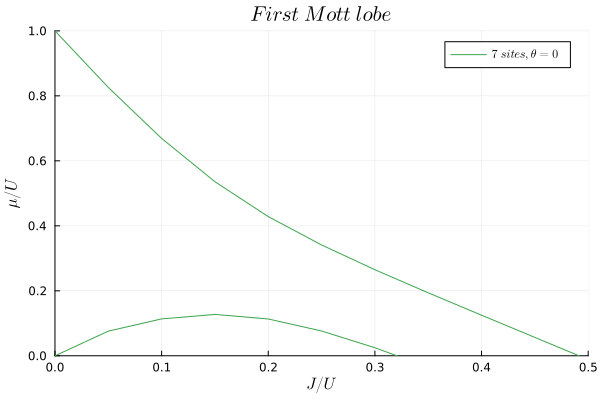

In [12]:
t = 0:0.05:0.50 
up = valuesofen-valuesofenlow
down = valuesofenup-valuesofen
plot(t,up, xlabel =L"J/U", ylabel=L"\mu/U", title =L"First~Mott~lobe", xlims=(0, 0.50), ylims=(0,1), label=false, color =3)# label =L"9~sites~down,\theta = \pi")
plot!(t,down , xlabel =L"J/U", ylabel=L"\mu/U", title =L"First~Mott~lobe", label =L"7~sites, \theta = 0", xlims=(0, 0.50), ylims=(0,1), palette=:default , color = 3)


In [98]:
#SPDM and fraction of condensate   
theta = 0
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   


lowerbound = []   
vectorsoflowerbound = []
 

for t in 0:0.05:0.5 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            #if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
            #    HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            #end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC)
    Eval, Evec = eigs(H , nev=1 , which=:SR)  
    G = Evec[:,1] 
#     Single particle density matrix 
    SPDM = spzeros(M,M)  
    for k in 1:M 
        for h in 1:M   
            if k == h 
                SPDM[k , k] = real(dot(G, matrixoccupation(k,D)*G))
            else  
                t = matrixofcreationann(k,h)*G
                SPDM[k , h] = real(dot(G,t))  
            end
        end  
    end   
    SPDM = Symmetric(SPDM, :L) 
    EvalSPDM, EvecSPDM = eigs(SPDM , nev=1, which =:LR, v0=ones(M))  
    real(EvalSPDM[1]/N)
#     SPDM = spzeros(M,M) 
#         for l in 1:M 
#             for h in 1:M   
#                 if l == h 
#                 SPDM[l , l] = real(dot(G, matrixoccupation(l,D)*G))
#                 else  
#                     t = matrixofcreationann(l,h)*G
#                     SPDM[l , h] = real(dot(G,t) )
#                 end
#             end  
#     end      
#     SPDM = round.(SPDM, digits= 5)
#     EvalSPDM, EvecSPDM = eigs(SPDM , nev=1, which =:LR)    
#     real(EvalSPDM[1]/N)  
    end
  

5×5 Symmetric{Float64, SparseMatrixCSC{Float64, Int64}}:
 1.0       0.940161  0.902852  0.902852  0.940161
 0.940161  1.0       0.940161  0.902852  0.902852
 0.902852  0.940161  1.0       0.940161  0.902852
 0.902852  0.902852  0.940161  1.0       0.940161
 0.940161  0.902852  0.902852  0.940161  1.0

In [101]:
EvalSPDM, EvecSPDM = eigs(SPDM , nev=1, which =:LR, v0=ones(M))        
real(EvalSPDM[1]/N)  


0.9372055342141549

In [106]:
#SPDM and fraction of condensate  
function fconde(N,M,theta) 
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   

fconde = Vector{Float64}() 
#fconde = []
    
for t in 0:0.25:5
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            #if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
            #    HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            #end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC)
    Eval, Evec = eigs(H , nev=1 , which=:SR)  
    G = Evec[:,1] 
    #G = round.(G,digits=5) 
    SPDM = spzeros(M,M) 
        for l in 1:M 
            for h in 1:M   
                if l == h 
                SPDM[l , l] = real(dot(G, matrixoccupation(l,D)*G) )
                else  
                    t = matrixofcreationann(l,h)*G
                    SPDM[l , h] = real(dot(G,t)  )
                end
            end  
        end    
    EvalSPDM, EvecSPDM = eigs(SPDM , nev=1, which =:LR, v0=ones(M))    
    push!(fconde, real(EvalSPDM[1]/N))   
    end
    return fconde
end

fconde (generic function with 1 method)

In [108]:
fcond = fconde(5,5,0);

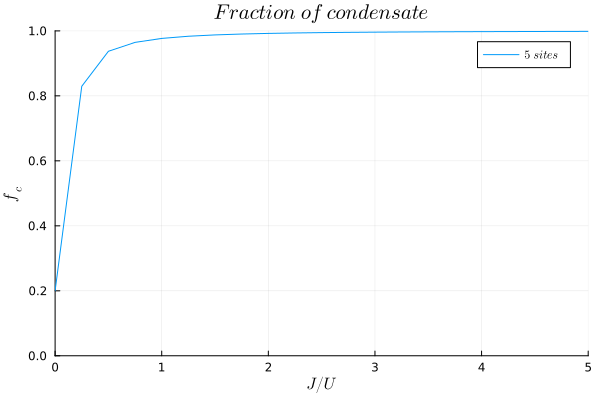

In [112]:
t = 0:0.25:5
plot(t,fcond, xlabel =L"J/U", ylabel=L"f_c", title =L"Fraction~of~condensate", label =L"5~sites", xlims=(0, 5), ylims=(0,1))

In [113]:
#SPDM and fraction of condensate  
function fcondeU(N,M,theta) 
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
J = 1
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  
    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            #if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] < j)   #### up  part  
            #    HkinHC[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expophc(theta, k, creation_ann(k,m, v[j])[2])#*expophc(theta, k, v[mod(j,D)+1])[mod(j,D)+1][mod(j,D)+1]  
            #end
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
Hkin = Symmetric(Hkin, :L) 
 

fcondeAU = Vector{Float64}() 
#fconde = []
    
for t in 0:0.5:20
    U=t 
    Vals = U*diagscomp
    Hint = spzeros(D,D)
    Hint[diagind(Hint)] = Vals; Hint  
    H= Hint + Hkin.*(Htheta  .+ HthetaHC)
    Eval, Evec = eigs(H , nev=1 , which=:SR)  
    G = Evec[:,1] 
    #G = round.(G,digits=5) 
    SPDM = spzeros(M,M) 
        for l in 1:M 
            for h in 1:M   
                if l == h 
                SPDM[l , l] = real(dot(G, matrixoccupation(l,D)*G) )
                else  
                    t = matrixofcreationann(l,h)*G
                    SPDM[l , h] = real(dot(G,t)  )
                end
            end  
        end    
    EvalSPDM, EvecSPDM = eigs(SPDM , nev=1, which =:LR, v0=ones(M))    
    push!(fcondeAU, real(EvalSPDM[1]/N))   
    end
    return fcondeAU
end

fcondeU (generic function with 1 method)

In [136]:
fcondeUJ = fcondeU(5,5,pi);

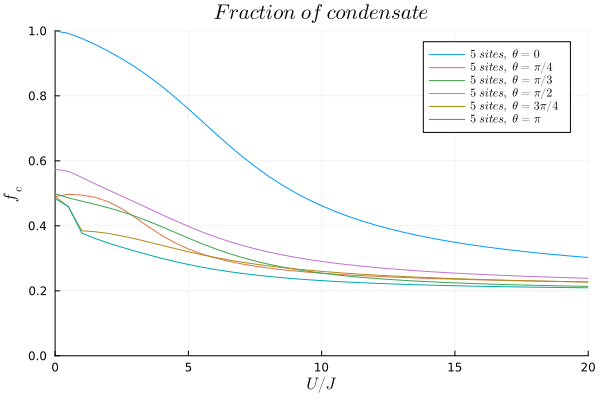

In [137]:
s = 0:0.5:20
plot!(s,fcondeUJ, xlabel =L"U/J", ylabel=L"f_c", title =L"Fraction~of~condensate", label =L"5~sites,~\theta=\pi", xlims=(0, 20), ylims=(0,1))

In [139]:
#savefig("plots-exact-diag-anyons-fraction-condesate-U-J-5-sites-5-particles.png")

In [15]:
###Variance 
function varianceforNthsite(N,M,theta,Nthsite) 
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte  
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   
    
    
###Variance for 3rd site
variance = []
v1 = matrixoccupation(Nthsite,D)
v2 = matrixoccupation(Nthsite,D)^2 


for t in 0:0.05:0.5 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     
    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC)
    #H= Hint + Hkin.*Htheta  + HkinHC.*HthetaHC
    Eval, Evec = eigs(H , nev=1 , which=:SR)   
    push!(variance, real((dot(Evec, v2*Evec) - (dot(Evec, v1*Evec))^2)))  
    end  
        return variance
end

varianceforNthsite (generic function with 1 method)

In [16]:
t = 0:0.05:0.50  
N=7 
M=7
theta = pi/3
Nthsite = 3
varian = varianceforNthsite(N,M,theta, Nthsite);

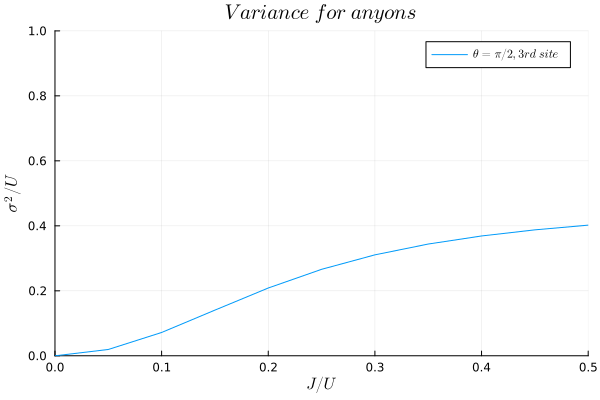

In [17]:
plot(t,varian, xlabel =L"J/U", ylabel=L"\sigma^{2}/U", title =L"Variance~for~anyons", xlims=(0, 0.50), ylims=(0,1), label=L"\theta=\pi/2,3rd~site")#, color =3)# label =L"9~sites~down,\theta = \pi")

In [14]:
sumofvariances = []  
cont = 0 
for i in Integer(ceil(M/4 + 1)):Integer(ceil(3M/4)) 
    push!(sumofvariances, varianceforNthsite(N,M,theta, i)) 
    cont += 1
end 

In [15]:
averageofvar = sum(sumofvariances)/cont;

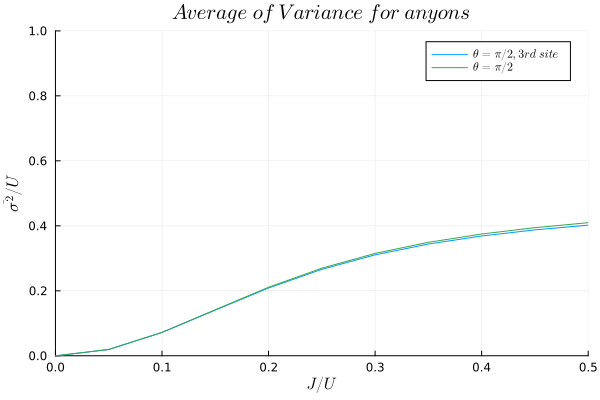

In [16]:
plot!(t,averageofvar, xlabel =L"J/U", ylabel=L"\bar{\sigma^2}/U", title =L"Average~of~Variance~for~anyons", xlims=(0, 0.50), ylims=(0,1), label=L"\theta=\pi/2", color =3)# label =L"9~sites~down,\theta = \pi")

In [17]:
###Order parameters

In [13]:
function matrixoccupation(k, D) 
    mat = spzeros(Complex{Float16}, D,D)
    for j in 1:D 
        mat[j,j] = occupation(k, v[j]) 
    end   
    return mat 
end

matrixoccupation (generic function with 1 method)

In [14]:
#Parity order parameter 
thetaop = pi
Op = exp(Matrix(sum(1im*thetaop*matrixoccupation(i,D) for i in 2:(N-1))) - 1im*thetaop*(N-2)*I);

In [16]:
Op = round.(Op, digits=5);

In [17]:
#String Order parameter (we fix the parameters i =1, j = N, and i<=k<j )  
#thetaop = pi/2
Ots = (exp(Matrix(sum(1im*thetaop*matrixoccupation(i,D) for i in 2:(N-1))) - 1im*thetaop*(N-2)*I))*(Matrix(matrixoccupation(N,D)) - I)
Os = (Matrix(matrixoccupation(1,D)) - I)*Ots;  
Os = round.(Os, digits=5);

In [19]:
function OPsforAnyons(N,M,theta) 
D=Int((factorial(M+N-1))/(factorial(M-1)*factorial(N)))   
v = generate_basis(N,M,D)  
#Array of tags 
T = []
for i in 1:length(v) 
     push!(T,  tag( v[i] , M )) 
end
#Order and we made a dictionary to Tsorted => indices
inds = sortperm(T);
Tsorted = T[inds];
#DictOfInds = Dict(zip(Tsorted, inds)) 
DictOfInds = Dict(Tsorted .=> inds) 
#Potential part 
Htheta = spzeros(Complex{Float64}, D, D)  
HthetaHC = spzeros(Complex{Float64}, D, D)  

for j in 1:D, k in 1:M, m in 1:M   
    if creation_ann(k,m,v[j]) == 0 
        continue     
    end 
    pos = DictOfInds[tag(creation_ann( k, m , v[j] )[2], M)] 
    if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
        if(pos < j)   #### up  part    
          HthetaHC[pos, j] = expophc(theta, m, v[j]) 
        end
        if(pos > j) ### down  part 
            Htheta[pos, j] =  expop(theta, k, creation_ann( k, m , v[j] )[2])  
        end
    end 
    #end
end      

diagscomp = [] 

for j in 1:D 
    sumsdeocup = []; 
    for k in 1:M
        push!(sumsdeocup, valdiags(k, v[j], M))
    end  
    push!(diagscomp, sum(sumsdeocup))    
end   
#Mostramos la parte de interaccion 
U=1
Vals = U*diagscomp
Hint = spzeros(D,D)
Hint[diagind(Hint)] = Vals; Hint   

###Order parameters
stringorderparameter = []   
parityorderparameter = []
 

for t in 0:0.25:5 
    J = t 
    Hkin = spzeros(Complex{Float64}, D, D)  
    HkinHC = spzeros(Complex{Float64}, D, D)  

    for j in 1:D, k in 1:M, m in 1:M   
        if creation_ann(k,m,v[j]) == 0 
            continue     
        end
        if (abs(k-m)==(M-1) || abs(k-m)==1 ) ##Boundary condition 1->M, M->1            
            if(DictOfInds[tag(creation_ann( k, m , v[j] )[2],M)] > j) ### down  part
                Hkin[DictOfInds[tag( creation_ann( k, m , v[j])[2] ,M)], j] = -J*(creation_ann( k, m , v[j])[1])#*expop(theta, m, v[j]) #*expop(theta, k, v[j])[j][j]   
            end
        end      
    end     

    Hkin = Symmetric(Hkin, :L) 
    H= Hint + Hkin.*(Htheta  .+ HthetaHC) 
        
    Eval, Evec = eigs(H , nev=1 , which=:SR)    
        
    fst = Os*Evec  
    snd = Op*Evec
    push!(stringorderparameter, real(sum((conj(Evec)).*fst)) )   
    push!(parityorderparameter, real(sum((conj(Evec)).*snd)) )   
    end  
        return parityorderparameter, stringorderparameter
end

OPsforAnyons (generic function with 1 method)

In [20]:
#real(sum((conj(trytry[6])).*(Op*trytry[6])))

In [21]:
#trytry = energyforanyons(3,3,theta)[2];

In [22]:
#latexify(trytry[1])

In [23]:
#latexify(trytry[1])

In [24]:
#transpose(conj(trytry[6]))*(Op*trytry[6])

In [57]:
 transpose(conj(OPsforAnyons(N,M, theta)))*(Op*OPsforAnyons(N,M,theta)) 

LoadError: MethodError: no method matching conj(::Tuple{Vector{Any}, Vector{Any}})
[0mClosest candidates are:
[0m  conj([91m::Union{Hermitian{T, S}, Symmetric{T, S}} where {T, S}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/symmetric.jl:368
[0m  conj([91m::ChainRulesCore.AbstractThunk[39m) at /home/ronaldo/.julia/packages/ChainRulesCore/a4mIA/src/tangent_types/thunks.jl:155
[0m  conj([91m::SparseVector{var"#s814", Ti} where {var"#s814"<:Complex, Ti<:Integer}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/sparsevector.jl:1166
[0m  ...

In [54]:
OPs = []  
N = 7
M = 7 
theta = pi #Theta de los aniones
push!(OPs, OPsforAnyons(N,M,theta)[1]) 
push!(OPs, OPsforAnyons(N,M,theta)[2]);

In [61]:
EDprevresultspi = load("data-for-seven-ED-OPs-pi-theta-anyon-pi.jld")  
EDprevresultsthreepifour = load("data-for-seven-ED-OPs-pi-theta-anyon-three_pi_over_four.jld")  
EDprevresultspiovertwo = load("data-for-seven-ED-OPs-pi-theta-anyon-pi_over_two.jld")  
EDprevresultspioverfour = load("data-for-seven-ED-OPs-pi-theta-anyon-pi_over_four.jld")  
EDprevresultspioverthree = load("data-for-seven-ED-OPs-pi-theta-anyon-pi_over_three.jld")  
EDprevresultszero = load("data-for-seven-ED-OPs-pi-theta-anyon-zero.jld")  

Dict{String, Any} with 2 entries:
  "OPs[2]" => Any[1.05296e-30, -0.0883398, -0.0777509, -0.0602476, -0.0469884, …
  "OPs[1]" => Any[1.0, 0.253467, 0.0616479, 0.0263254, 0.0135138, 0.00745818, 0…

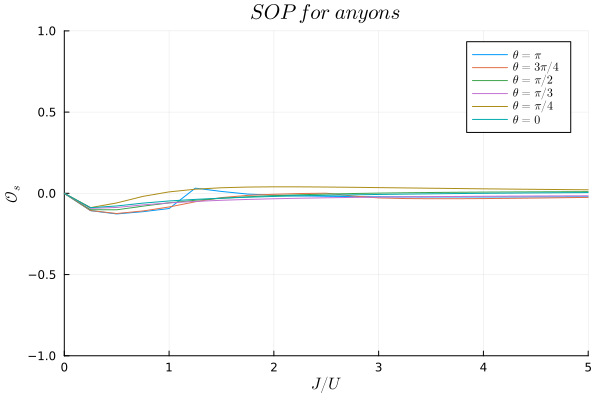

In [63]:
plot(t, [EDprevresultspi["OPs[2]"] EDprevresultsthreepifour["OPs[2]"] EDprevresultspiovertwo["OPs[2]"] EDprevresultspioverfour["OPs[2]"] EDprevresultspioverthree["OPs[2]"] EDprevresultszero["OPs[2]"]] , xlabel =L"J/U", ylabel= L"\mathcal{O}_s", title =L"SOP~for~anyons", xlims=(0, 5.0), ylims=(-1,1), label=[L"\theta=\pi" L"\theta=3\pi/4" L"\theta=\pi/2" L"\theta=\pi/3" L"\theta=\pi/4" L"\theta=0"])# label =L"9~sites~down,\theta = \pi")

In [64]:
savefig("SOP-pi-Exact-Diag-seven-sites-thetas.png")

In [57]:
#savefig("SOP-Exact-seven-sites-thetas.png")

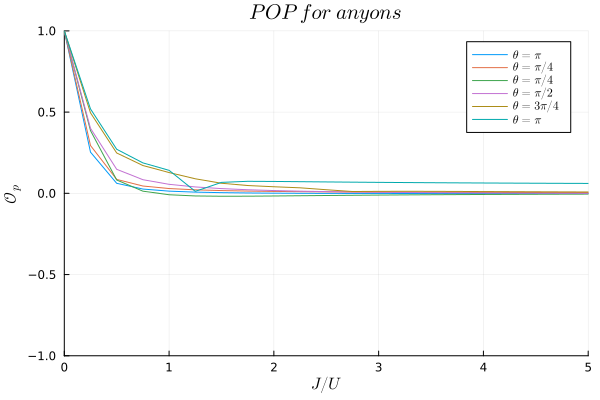

In [58]:
t = 0:0.25:5
plot!(t,OPs[1]  , xlabel =L"J/U", ylabel= L"\mathcal{O}_p", title =L"POP~for~anyons", xlims=(0, 5.0), ylims=(-1,1), label=L"\theta=\pi")# label =L"9~sites~down,\theta = \pi")

In [59]:
#@save "data-for-seven-ED-OPs-pi-theta-anyon-pi.jld" OPs[1] OPs[2]

In [60]:
#savefig("POP-pi-Exact-Diag-seven-sites-thetas.png")

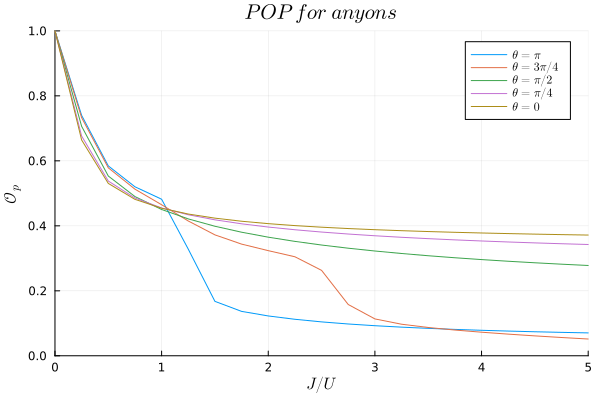

In [105]:
#plot(t, [EDprevresultspi["OPs[2]"] EDprevresultsthreepifour["OPs[2]"] EDprevresultspiovertwo["OPs[2]"] EDprevresultspioverfour["OPs[2]"] OPs[2]] , xlabel =L"J/U", ylabel= L"\mathcal{O}_p", title =L"POP~for~anyons", xlims=(0, 5.0), ylims=(0,1), label=[L"\theta=\pi" L"\theta=3\pi/4" L"\theta=\pi/2" L"\theta=\pi/4" L"\theta=0"])# label =L"9~sites~down,\theta = \pi")

In [106]:
#savefig("POP-Exact-seven-sites-thetas.png")